In [1]:
import os
# set working directory to root 
os.chdir('..')
os.getcwd()

'/home/qiangzibro/2021-math-model-code'

In [20]:
import pandas as pd, numpy as np
from common.io import load, load_table
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

plt.style.use('ggplot')
# Linux上解决字体问题
plt.rcParams['font.sans-serif']= ['Noto Serif CJK JP'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False 
FIGSIZE = (12,8)
FORMAT = "pdf"

In [219]:
table = load_table("C")

In [157]:
table['1'].columns

Index(['Unnamed: 0', '监测时间', '地点', 'SO2监测浓度(μg/m³)', 'NO2监测浓度(μg/m³)',
       'PM10监测浓度(μg/m³)', 'PM2.5监测浓度(μg/m³)', 'O3监测浓度(μg/m³)', 'CO监测浓度(mg/m³)',
       '温度(℃)', '湿度(%)', '大气压(mBar)', '风速(m/s)', '风向(°)'],
      dtype='object')

<AxesSubplot:xlabel='监测时间', ylabel='[湿度(%)]'>

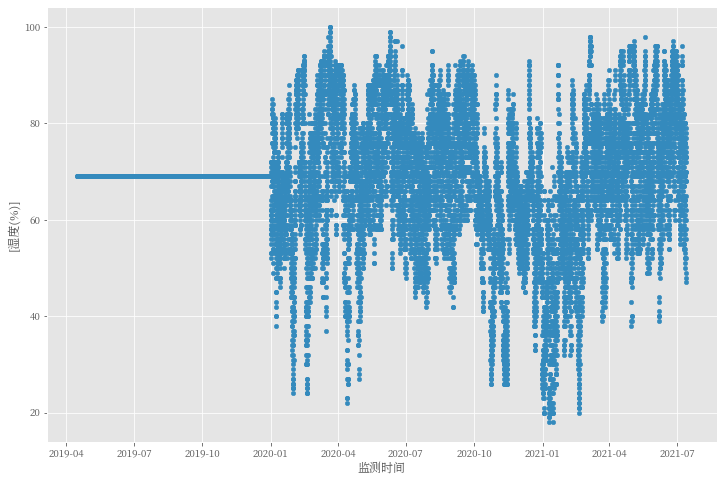

In [158]:
df = table['1']
feature = '湿度(%)'
df.plot.scatter(x='监测时间', y=[feature], figsize=(12, 8))

In [ ]:
df[]

In [204]:
df.loc[df['监测时间'] <= '2020-01-01', feature] = 0

0       0
1       0
2       0
3       0
4       0
       ..
6142    0
6143    0
6144    0
6145    0
6146    0
Name: 湿度(%), Length: 6147, dtype: int64

In [205]:
df = table['1']
df.loc[df['监测时间'] <= '2020-01-01', feature] = 0
df[feature]

0         0
1         0
2         0
3         0
4         0
         ..
19486    74
19487    75
19488    77
19489    78
19490    79
Name: 湿度(%), Length: 19491, dtype: int64

0       2019-04-16 00:00:00
1       2019-04-16 01:00:00
2       2019-04-16 02:00:00
3       2019-04-16 03:00:00
4       2019-04-16 04:00:00
                ...        
19486   2021-07-13 03:00:00
19487   2021-07-13 04:00:00
19488   2021-07-13 05:00:00
19489   2021-07-13 06:00:00
19490   2021-07-13 07:00:00
Name: 监测时间, Length: 19491, dtype: datetime64[ns]

## 缺失值填充

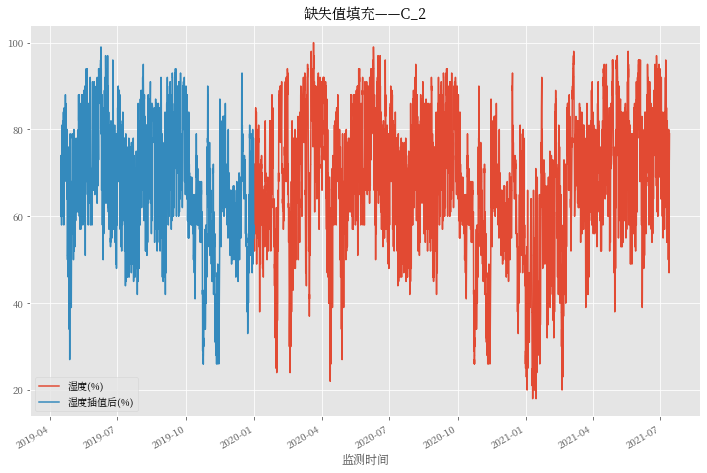

In [296]:
selector = data_df['date'] <= '2020-01-01'
df = table['1']
df.loc[df['监测时间'] <= '2020-01-01', feature] = np.nan
tmp =df[feature].copy()
next_stage = tmp[(df['监测时间'] >= '2020-04-16') & (df['监测时间'] < '2020-12-30 01:00:00')]
df['湿度插值后(%)'] = np.nan
df.loc[df['监测时间'] < '2020-01-01', '湿度插值后(%)'] = list(next_stage) #???
df.plot.line(x='监测时间', y=[feature,"湿度插值后(%)"], figsize=(12,8))
plt.title("缺失值填充——C_2")
plt.savefig("results/缺失值填充——C_2.{}".format(FORMAT), format=FORMAT)

In [306]:
def write_excel(name, frame):
    writer = pd.ExcelWriter("data/" + name + '.xlsx', engine='xlsxwriter')
    for i in range(3):
        frame[str(i)].to_excel(writer, sheet_name=str(i))
    writer.save()
write_excel('C', table)

# 1.时间特征

## 1.1 连续时间

持续时间：
浏览时长；
间隔时间：
购买/点击距今时长；
距离假期的前后时长（节假日前和节假日后可能会出现明显的数据波动）；
## 1.2 离散时间

年、季度、季节、月、星期、日、时 等；

基本特征，如果用 Xgboost 模型可以进行 one-hot 编码；
如果类别比较多，可以尝试平均数编码（Mean Encoding）。
或者取 cos/sin 将数值的首位衔接起来，比如说 23 点与 0 点很近，星期一和星期天很近。
节假日、节假日第 n 天、节假日前 n 天、节假日后 n 天；

数据可能会随着节假日的持续而发生变化，比如说递减；
节假日前/后可能会出现数据波动；
不放假的人造节日如 5.20、6.18、11.11 等也需要考虑一下；
一天的某个时间段；

上午、中午、下午、傍晚、晚上、深夜、凌晨等；
年初、年末、月初、月末、周内、周末；

基本特征；
高峰时段、是否上班、是否营业、是否双休日；

主要根据业务场景进行挖掘。

In [140]:
# 构造时间特征
def get_time_fe(data, col, n, one_hot=False, drop=True):
    '''
    data: DataFrame
    col: column name
    n: 时间周期
    '''
    data[col + '_sin'] = round(np.sin(2*np.pi / n * data[col]), 6)
    data[col + '_cos'] = round(np.cos(2*np.pi / n * data[col]), 6)
    if one_hot:
        ohe = OneHotEncoder()
        X = OneHotEncoder().fit_transform(data[col].values.reshape(-1, 1)).toarray()
        df = pd.DataFrame(X, columns=[col + '_' + str(int(i)) for i in range(X.shape[1])])
        data = pd.concat([data, df], axis=1)
    if drop:
        data = data.drop(col, axis=1)
    return data

data_df = table['1']

# 年、季度、季节、月、星期、日、时  
data_df['date'] = pd.to_datetime(data_df['监测时间'], format="%m/%d/%y")
data_df['quarter']=data_df['date'].dt.quarter
data_df['month'] = data_df['date'].dt.month
data_df['day'] = data_df['date'].dt.day
data_df['dayofweek'] = data_df['date'].dt.dayofweek
data_df['weekofyear'] = data_df['date'].dt.week   # 一年中的第几周

# Series.dt 下有很多属性，可以去看一下是否有需要的。
data_df['is_year_start'] = data_df['date'].dt.is_year_start
data_df['is_year_end'] = data_df['date'].dt.is_year_end
data_df['is_quarter_start'] = data_df['date'].dt.is_quarter_start
data_df['is_quarter_end'] = data_df['date'].dt.is_quarter_end
data_df['is_month_start'] = data_df['date'].dt.is_month_start
data_df['is_month_end'] = data_df['date'].dt.is_month_end

# data_df = get_time_fe(data_df, 'hour', n=24, one_hot=False, drop=False)
data_df = get_time_fe(data_df, 'day', n=31, one_hot=False, drop=True)
data_df = get_time_fe(data_df, 'dayofweek', n=7, one_hot=True, drop=True)
# data_df = get_time_fe(data_df, 'season', n=4, one_hot=True, drop=True)
data_df = get_time_fe(data_df, 'month', n=12, one_hot=True, drop=True)
data_df = get_time_fe(data_df, 'weekofyear', n=53, one_hot=False, drop=True)


/usr/miniconda3/envs/math/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [141]:
data_df.columns

Index(['Unnamed: 0', '监测时间', '地点', 'SO2监测浓度(μg/m³)', 'NO2监测浓度(μg/m³)',
       'PM10监测浓度(μg/m³)', 'PM2.5监测浓度(μg/m³)', 'O3监测浓度(μg/m³)', 'CO监测浓度(mg/m³)',
       '温度(℃)', '湿度(%)', '大气压(mBar)', '风速(m/s)', '风向(°)', 'date', 'quarter',
       'is_year_start', 'is_year_end', 'is_quarter_start', 'is_quarter_end',
       'is_month_start', 'is_month_end', 'day_sin', 'day_cos', 'dayofweek_sin',
       'dayofweek_cos', 'dayofweek_0', 'dayofweek_1', 'dayofweek_2',
       'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'month_sin',
       'month_cos', 'month_0', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'weekofyear_sin', 'weekofyear_cos'],
      dtype='object')

# 2. 聚合特征
## 2.1 统计值
基于历史数据构造长中短期的统计值，包括前 n 天/周期内的：

四分位数；
中位数、平均数、偏差；
偏度、峰度；
挖掘数据的偏离程度和集中程度；
离散系数；
挖掘离散程度
这里可以用自相关系数（autocorrelation）挖掘出周期性。

除了对数据进行统计外，也可以对节假日等进行统计，以刻画历史数据中所含节假日的情况。（还可以统计未来的节假日的情况。）

In [294]:
# 画出自相关性系数图
from pandas.plotting import autocorrelation_plot
# autocorrelation_plot(data['value'])

# 构造过去 n 天的统计数据
def get_statis_n_days_num(data, col, n):
    temp = pd.DataFrame()
    for i in range(n):
        temp = pd.concat([temp, data[col].shift((i+1)*24)], axis=1)
        data['avg_'+ str(n) +'_days_' + col] = temp.mean(axis=1)
        data['median_'+ str(n) +'_days_' + col] = temp.median(axis=1)
        data['max_'+ str(n) +'_days_' + col] = temp.max(axis=1)
        data['min_'+ str(n) +'_days_' + col] = temp.min(axis=1)
        data['std_'+ str(n) +'_days_' + col] = temp.std(axis=1)
        data['mad_'+ str(n) +'_days_' + col] = temp.mad(axis=1)
        data['skew_'+ str(n) +'_days_' + col] = temp.skew(axis=1)
        data['kurt_'+ str(n) +'_days_' + col] = temp.kurt(axis=1)
        data['q1_'+ str(n) +'_days_' + col] = temp.quantile(q=0.25, axis=1)
        data['q3_'+ str(n) +'_days_' + col] = temp.quantile(q=0.75, axis=1)
        data['var_'+ str(n) +'_days_' + col] = data['std_'+ str(n) +'_days_' + col]/data['avg_'+ str(n) +'_days_' + col]  # 离散系数
    return data

data_df = get_statis_n_days_num(data_df, feature, n=7)
data_df = get_statis_n_days_num(data_df, feature, n=14)
data_df = get_statis_n_days_num(data_df, feature, n=21)
data_df = get_statis_n_days_num(data_df, feature, n=28)

In [ ]:
plt.figure(figsize=FIGSIZE)
plt.suptitle(f"湿度自相关系数", size=20)

autocorrelation_plot(data_df[feature])
plt.savefig("results/湿度自相关系数.{}".format(FORMAT), format=FORMAT)

In [ ]:
y = [
    'q1_'+ str(7) +f'_days_{feature}',
    'q3_'+ str(7) +f'_days_{feature}',
]
selector = data_df['date'] >= '2019-04-16'
data_df[selector].plot(x='date', y=y, title=None, figsize=(15,8))
plt.suptitle(f"湿度q1和q3", size=20)
plt.savefig("results/湿度q1和q3."+FORMAT, format=FORMAT)
# plt.close()

In [ ]:
# 过去时间段监测浓度均值
y = [
    'avg_'+ str(i) +f'_days_{feature}' for i in [7, 14, 21]
]


fig, axes = plt.subplots(3, 4, figsize=(18,25))
for i in range(1, 13):
    year = '2021' if i == 12 else '2020'
    j = 1 if i == 12 else i+1
    selector = (data_df['date'] > f'2020-{i}-01') & (data_df['date'] < f'{year}-{j}-01')
    ax = axes[(i-1)//4][(i-1)%4]
    x_axis = ax.axes.get_xaxis()
    x_axis.set_visible(False)
    
    data_df[selector].plot.line(x='date', y=y, title=f'{i}月', ax=ax)
    
plt.suptitle(f"2020年湿度过去若干天的平均值", size=20, y=0.92)
plt.savefig("results/2020年湿度过去若干天的平均值."+FORMAT, format=FORMAT)

In [ ]:
# 过去时间段监测浓度均值
y = [
    'var_'+ str(i) +f'_days_{feature}' for i in [7, 14, 21]
]


fig, axes = plt.subplots(3, 4, figsize=(18,25))
for i in range(1, 13):
    year = '2021' if i == 12 else '2020'
    j = 1 if i == 12 else i+1
    selector = (data_df['date'] > f'2020-{i}-01') & (data_df['date'] < f'{year}-{j}-01')
    ax = axes[(i-1)//4][(i-1)%4]
    x_axis = ax.axes.get_xaxis()
    x_axis.set_visible(False)
    
    data_df[selector].plot.line(x='date', y=y, title=f'{i}月', ax=ax)
    
plt.suptitle(f"2020年湿度过去若干天的方差", size=20, y=0.92)
plt.savefig("results/2020年湿度过去若干天的方差."+FORMAT, format=FORMAT)

## 2.2 同期值
前 n 个周期/天/月/年的同期值；

In [ ]:
# n 个星期前同期特征
data_df[f'ago_7_day_{feature}'] = data_df[feature].shift(7*24)
data_df[f'ago_14_day_{feature}'] = data_df[feature].shift(14*24)
data_df[f'ago_21_day_{feature}'] = data_df[feature].shift(21*24)
data_df[f'ago_28_day_{feature}'] = data_df[feature].shift(28*24)

# # 昨天的同期特征
data_df[f'ago_1_day_{feature}'] = data_df[feature].shift(1*24)

In [ ]:
# 过去时间段监测浓度均值
y = [
    'var_'+ str(i) +f'_days_{feature}' for i in [7, 14, 21]
]


fig, axes = plt.subplots(3, 4, figsize=(18,25))
for i in range(1, 13):
    year = '2021' if i == 12 else '2020'
    j = 1 if i == 12 else i+1
    selector = (data_df['date'] > f'2020-{i}-01') & (data_df['date'] < f'{year}-{j}-01')
    ax = axes[(i-1)//4][(i-1)%4]
    x_axis = ax.axes.get_xaxis()
    x_axis.set_visible(False)
    
    data_df[selector].plot.line(x='date', y=y, title=f'{i}月', ax=ax)
    
plt.suptitle(f"2020年湿度过去若干天的方差", size=20, y=0.92)
plt.savefig("results/2020年湿度过去若干天的方差."+FORMAT, format=FORMAT)

In [ ]:
y = [
    feature,
    f'ago_1_day_{feature}',
    f'ago_7_day_{feature}',
    f'ago_14_day_{feature}',
    f'ago_21_day_{feature}',
    f'ago_28_day_{feature}'
]

fig, axes = plt.subplots(2, 3, figsize=(18,25))
for i in range(6):
    ax = axes[i//3][i%3]
    selector = (data_df['date'] > f'2020-01-01') & (data_df['date'] < f'2021-01-01')
    data_df[selector].plot(x='date', y=y[i], title=None, ax=ax)
plt.suptitle(f"湿度-同期值分析", size=20, y=0.91)
plt.savefig("results/湿度-同期值分析."+FORMAT, format=FORMAT)

# 3.交叉特征

类别特征间组合构成新特征：

笛卡尔积，比如星期和小时：Mon_10（星期一的十点）；

类别特征和连续特征：

连续特征分桶后进行笛卡尔积；

基于类别特征进行 groupby 操作，类似聚合特征的构造；

连续特征和连续特征：

同比和环比（一阶差分）：反应同期或上一个统计时段的变换大小；

二阶差分：反应变化趋势；

比值；
特征交叉一般从重要特征线下手，慢工出细活。

In [18]:
# 一阶差分
data_df['ago_28_21_day_{feature}_trend'] = data_df['ago_28_day_{feature}'] - data_df['ago_21_day_{feature}']
data_df['ago_21_14_day_{feature}_trend'] = data_df['ago_21_day_{feature}'] - data_df['ago_14_day_{feature}']
data_df['ago_14_7_day_{feature}_trend'] = data_df['ago_14_day_{feature}'] - data_df['ago_7_day_{feature}']
data_df['ago_7_1_day_{feature}_trend'] = data_df['ago_7_day_{feature}'] - data_df['ago_1_day_{feature}']

<AxesSubplot:xlabel='date'>

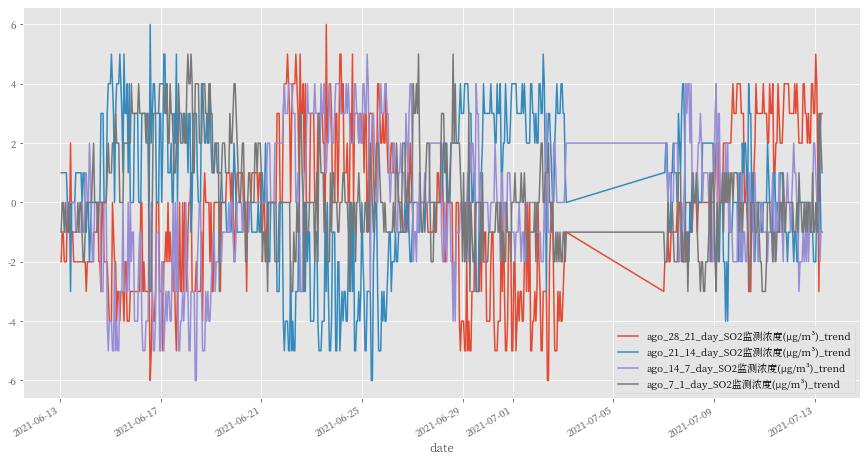

In [19]:
y = [
    'ago_28_21_day_{feature}_trend',
    'ago_21_14_day_{feature}_trend',
    'ago_14_7_day_{feature}_trend',
    'ago_7_1_day_{feature}_trend'
]
selector = data_df['date'] > '2021-06-13'
data_df[selector].plot(x='date', y=y, title=None, figsize=(15,8))

## 湿度补全

In [136]:
data_df

,Unnamed: 0,监测时间,地点,SO2监测浓度(μg/m³),NO2监测浓度(μg/m³),PM10监测浓度(μg/m³),PM2.5监测浓度(μg/m³),O3监测浓度(μg/m³),CO监测浓度(mg/m³),温度(℃),...,median_28_days_湿度(%),max_28_days_湿度(%),min_28_days_湿度(%),std_28_days_湿度(%),mad_28_days_湿度(%),skew_28_days_湿度(%),kurt_28_days_湿度(%),q1_28_days_湿度(%),q3_28_days_湿度(%),var_28_days_湿度(%)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19486,19486.0,2021-07-13 03:00:00,监测点C,6.0,30.0,34.0,13.0,11.0,0.5,30.4,...,83.5,93.0,72.0,6.236414,5.250000,0.006953,-1.109367,77.00,87.25,0.074976
19487,19487.0,2021-07-13 04:00:00,监测点C,6.0,29.0,34.0,12.0,8.0,0.5,30.0,...,84.0,93.0,73.0,5.660945,4.892857,-0.004040,-1.068681,79.00,88.25,0.067192
19488,19488.0,2021-07-13 05:00:00,监测点C,6.0,27.0,30.0,12.0,7.0,0.5,29.6,...,85.5,95.0,73.0,5.592417,4.785714,-0.098977,-0.772018,80.75,90.25,0.065518
19489,19489.0,2021-07-13 06:00:00,监测点C,7.0,24.0,20.0,13.0,8.0,0.5,29.2,...,85.5,96.0,74.0,5.279866,4.400510,-0.116787,-0.352645,82.00,90.25,0.061317


In [128]:
df = table['1']
selector = df['date'] < '2020-01-01'
# df[selector]
df.plot.scatter(x='监测时间', y=[feature], figsize=(12, 8))

TypeError: '<' not supported between instances of 'Timestamp' and 'str'

<AxesSubplot:xlabel='监测时间', ylabel='[湿度(%)]'>

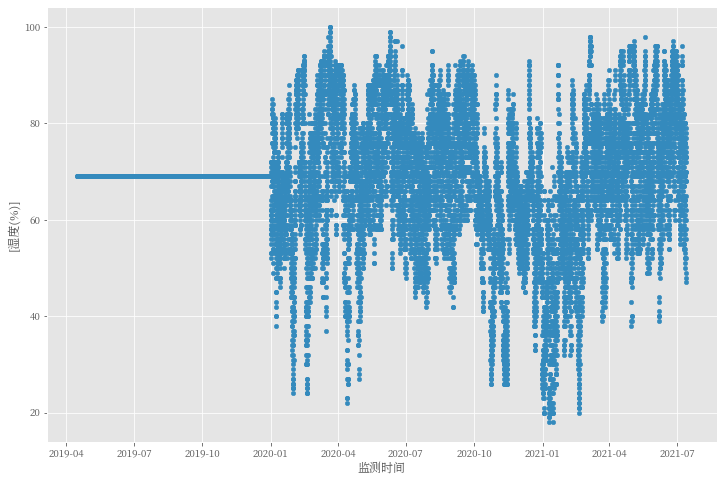

In [121]:
df = table['1']
df.plot.scatter(x='监测时间', y=[feature], figsize=(12, 8))

# Thanks
1. 【时间序列】时序特征挖掘的奇技淫巧，阿泽，https://mp.weixin.qq.com/s/j-TBNSSCafeqE8qkfeF9qw